# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

from PIL import Image

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.13.7 | packaged by conda-forge | (main, Sep  3 2025, 14:30:35) [GCC 14.3.0]
PyTorch version 2.6.0
Torchvision version 0.21.0
Numpy version 2.3.3
Pandas version 2.3.2


# Create Pytorch Dataset and Dataloader

In [52]:
# Create the playing card dataset class

class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self): # How many examples are in the dataset?
        return len(self.data)

    def __getitem__(self, idx): # Takes the index location in the dataset and returns one item.
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

# PyTorch Model

In [ ]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        # Where we define all the parts of the model.
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1]) # remove last base layer from that model

        enet_out_size = 1280 # default number of outputs from efficient net b0
        # Make a classifier
        self.classifier = nn.Linear(enet_out_size, num_classes) # convert 1280 outputs into 53 classes

    def forward(self, x):
        # Connect these parts and return the output.
        x = self.features(x)
        output = self.classifier(x)
        return output

# Train the model

In [ ]:
# transform data to 128 x 128 array and make it a tensor
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# training, validation, and testing folders
train_folder = "/home/asunkari/neuro-ml/01_learn_pytorch/archive/train"
valid_folder = "/home/asunkari/neuro-ml/01_learn_pytorch/archive/valid"
test_folder = "/home/asunkari/neuro-ml/01_learn_pytorch/archive/test"

# make a pytorch dataset
train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

# use the dataloader to load the datasets; shuffle the training data; batch into 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# define number of epochs and create arrays to hold loss data over epochs
num_epochs = 5
train_losses, val_losses = [], []

# specify hardware
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# instantiate a model and assign it to the hardware
model = SimpleCardClassifier(num_classes=53)
model.to(device)

# define loss function and optimization function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# create training loop
for epoch in range(num_epochs):

    # Training phase
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc='Training loop'):

        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()                                      # do not accumulate gradients
        outputs = model(images)
        loss = criterion(outputs, labels)                          # feed outputs and labels into the loss function
        loss.backward()                                            # backpropagation to adjust weights
        optimizer.step()                                           # update paramter weights
        running_loss += loss.item() * labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():  # disable gradient tracking for this case
        for images, labels in tqdm(val_loader, desc='Validation loop'):

            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Validation loop: 100%|██████████| 9/9 [00:03<00:00,  2.45it/s]


Epoch 1/5 - Train loss: 1.5822625131446943, Validation loss: 0.389460851111502


Validation loop: 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


Epoch 2/5 - Train loss: 0.5565204840204273, Validation loss: 0.23915256644194982


Validation loop: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch 3/5 - Train loss: 0.3487286731241132, Validation loss: 0.16801367863169256


Validation loop: 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


Epoch 4/5 - Train loss: 0.22116114301577694, Validation loss: 0.11045790787013073


Validation loop: 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]

Epoch 5/5 - Train loss: 0.2035427976943013, Validation loss: 0.18287086458701007


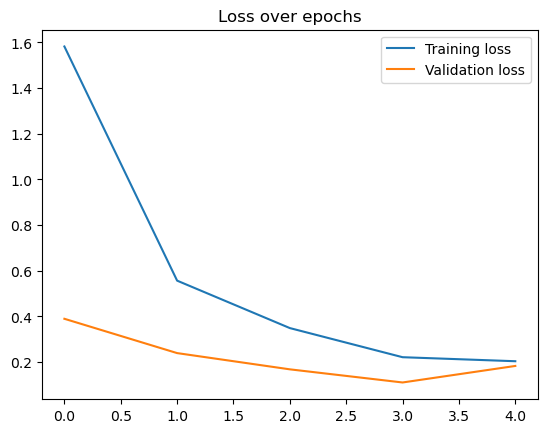

In [63]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [1]:
import torch
import torchvision.transforms as transforms


# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/home/asunkari/neuro-ml/01_learn_pytorch/archive/test/two of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

NameError: name 'Image' is not defined